<b>Important:</b> Save prepared/modified datasets locally to <code>../data/prepared/</code>


In [1]:
import sys
import pandas as pd
sys.path.insert(1, '../../../../utils')
from numpy import log, ndarray, array
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show, subplots
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from dslabs_functions import evaluate_approach, plot_multiline_chart, plot_bar_chart, get_variable_types, plot_multibar_chart, define_grid, derive_date_variables, HEIGHT, plot_multi_scatters_chart, dummify, CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_evaluation_results
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
filename = "../../data/prepared/flight_enc2.csv"
data: DataFrame = read_csv(filename, na_values="")
print("Shape:", data.shape)

Shape: (200000, 61)


In [3]:
data = data.sort_values("FlightDate").reset_index(drop=True)

split_idx = int(0.7 * len(data))
train_raw = data.iloc[:split_idx].copy()
test_raw  = data.iloc[split_idx:].copy()

print(train_raw.shape, test_raw.shape)

(140000, 61) (60000, 61)


In [4]:
vars_types = get_variable_types(train_raw)

numeric_vars = vars_types["numeric"].copy()
binary_vars  = vars_types["binary"].copy()

print("Numeric:", len(numeric_vars))
print("Binary:", len(binary_vars))

Numeric: 55
Binary: 5


In [5]:
all_nan_cols = data.columns[data.isna().all()].tolist()
print("Dropping all-NaN columns:", all_nan_cols)

if len(all_nan_cols) > 0:
    train_raw = train_raw.drop(columns=all_nan_cols)
    test_raw  = test_raw.drop(columns=all_nan_cols)

target = "Cancelled"

Dropping all-NaN columns: []


# Imputation Method 1

In [6]:
def mvi_simple(
    train: DataFrame,
    test: DataFrame,
    target: str = "Cancelled"
) -> tuple[DataFrame, DataFrame]:
    """
    Approach 1 – Simple imputation (no leakage):
      - continuous numeric: mean
      - binary 0/1 columns: most_frequent (mode)
      - non-numeric columns (e.g., FlightDate): kept unchanged
      - target column: copied as-is, never imputed
    """
    train = train.copy()
    test  = test.copy()

    # --- 0) Separate target so we NEVER impute it ---
    if target not in train.columns or target not in test.columns:
        raise KeyError(f"Target column '{target}' missing from train/test.")

    y_train = train[target].copy()
    y_test  = test[target].copy()

    train_X = train.drop(columns=[target])
    test_X  = test.drop(columns=[target])

    # --- 1) Identify numeric vs non-numeric in FEATURES only ---
    numeric_cols = train_X.select_dtypes(include="number").columns.tolist()
    other_cols   = [c for c in train_X.columns if c not in numeric_cols]

    # among numeric, split binary (0/1) vs continuous
    binary_cols: list[str] = []
    for col in numeric_cols:
        uniq = set(train_X[col].dropna().unique())
        if uniq.issubset({0, 1}):
            binary_cols.append(col)

    continuous_cols = [c for c in numeric_cols if c not in binary_cols]

    parts_tr: list[DataFrame] = []
    parts_te: list[DataFrame] = []

    # --- 2) Continuous numeric → mean ---
    if continuous_cols:
        imp_num = SimpleImputer(strategy="mean")
        tr_num = DataFrame(
            imp_num.fit_transform(train_X[continuous_cols]),
            columns=continuous_cols,
            index=train_X.index,
        )
        te_num = DataFrame(
            imp_num.transform(test_X[continuous_cols]),
            columns=continuous_cols,
            index=test_X.index,
        )
        parts_tr.append(tr_num)
        parts_te.append(te_num)

    # --- 3) Binary (0/1) → most_frequent ---
    if binary_cols:
        imp_bin = SimpleImputer(strategy="most_frequent")
        tr_bin = DataFrame(
            imp_bin.fit_transform(train_X[binary_cols]),
            columns=binary_cols,
            index=train_X.index,
        )
        te_bin = DataFrame(
            imp_bin.transform(test_X[binary_cols]),
            columns=binary_cols,
            index=test_X.index,
        )
        parts_tr.append(tr_bin)
        parts_te.append(te_bin)

    # --- 4) Non-numeric (e.g., FlightDate) → unchanged ---
    if other_cols:
        parts_tr.append(train_X[other_cols].copy())
        parts_te.append(test_X[other_cols].copy())

    # --- 5) Recombine features ---
    train_out_X = concat(parts_tr, axis=1)
    test_out_X  = concat(parts_te, axis=1)

    # align & sort columns to be *identical* between train/test
    common_cols = sorted(set(train_out_X.columns) & set(test_out_X.columns))
    train_out_X = train_out_X[common_cols]
    test_out_X  = test_out_X[common_cols]

    # --- 6) Add back target (unchanged) ---
    train_out = concat([train_out_X, y_train], axis=1)
    test_out  = concat([test_out_X,  y_test],  axis=1)

    return train_out, test_out


# Imputation Method 2

In [7]:
def mvi_knn(
    train: DataFrame,
    test: DataFrame,
    target: str = "Cancelled",
    k: int = 5
) -> tuple[DataFrame, DataFrame]:
    """
    Approach 2 – KNN imputation (aligned with mvi_simple):
      - numeric (continuous + binary): KNNImputer
      - non-numeric (e.g., FlightDate): kept unchanged
      - binary columns rounded back to 0/1
      - target column: copied as-is, never used in KNN, never imputed
    """
    train = train.copy()
    test  = test.copy()

    # --- 0) Separate target so we NEVER impute or use it in distances ---
    if target not in train.columns or target not in test.columns:
        raise KeyError(f"Target column '{target}' missing from train/test.")

    y_train = train[target].copy()
    y_test  = test[target].copy()

    train_X = train.drop(columns=[target])
    test_X  = test.drop(columns=[target])

    # --- 1) Identify numeric vs non-numeric in FEATURES only ---
    numeric_cols = train_X.select_dtypes(include="number").columns.tolist()
    other_cols   = [c for c in train_X.columns if c not in numeric_cols]

    # among numeric, split binary (0/1) vs continuous
    binary_cols: list[str] = []
    for col in numeric_cols:
        uniq = set(train_X[col].dropna().unique())
        if uniq.issubset({0, 1}):
            binary_cols.append(col)

    continuous_cols = [c for c in numeric_cols if c not in binary_cols]

    knn_cols = numeric_cols  # all numeric go into KNN

    parts_tr: list[DataFrame] = []
    parts_te: list[DataFrame] = []

    # --- 2) numeric (cont + binary) → KNNImputer ---
    if knn_cols:
        imp_knn = KNNImputer(n_neighbors=k)
        tr_knn = DataFrame(
            imp_knn.fit_transform(train_X[knn_cols]),
            columns=knn_cols,
            index=train_X.index,
        )
        te_knn = DataFrame(
            imp_knn.transform(test_X[knn_cols]),
            columns=knn_cols,
            index=test_X.index,
        )

        # round binary columns back to 0/1
        for col in binary_cols:
            tr_knn[col] = tr_knn[col].round().astype(int)
            te_knn[col] = te_knn[col].round().astype(int)

        parts_tr.append(tr_knn)
        parts_te.append(te_knn)

    # --- 3) Non-numeric (e.g., FlightDate) → unchanged ---
    if other_cols:
        parts_tr.append(train_X[other_cols].copy())
        parts_te.append(test_X[other_cols].copy())

    # --- 4) Recombine features ---
    train_out_X = concat(parts_tr, axis=1)
    test_out_X  = concat(parts_te, axis=1)

    # align & sort columns to be identical
    common_cols = sorted(set(train_out_X.columns) & set(test_out_X.columns))
    train_out_X = train_out_X[common_cols]
    test_out_X  = test_out_X[common_cols]

    # --- 5) Add back target (unchanged) ---
    train_out = concat([train_out_X, y_train], axis=1)
    test_out  = concat([test_out_X,  y_test],  axis=1)

    return train_out, test_out

# Evaluation

In [8]:
train_simple, test_simple = mvi_simple(train_raw, test_raw, target=target)
train_knn,    test_knn    = mvi_knn(train_raw, test_raw, target=target, k=7)

print("Simple MVI shapes:", train_simple.shape, test_simple.shape)
print("KNN    MVI shapes:", train_knn.shape,    test_knn.shape)

Simple MVI shapes: (140000, 61) (60000, 61)
KNN    MVI shapes: (140000, 61) (60000, 61)


In [9]:
file_tag_simple = "flight_mvi_simple"
file_tag_knn    = "flight_mvi_knn"

cols_to_drop = [
    "FlightDate",
    "DepDelay",
    "DepartureDelayGroups",
    "ArrDelay",
    "ArrivalDelayGroups",
]

train_simple_eval = train_simple.drop(columns=cols_to_drop, errors="ignore").copy()
test_simple_eval  = test_simple.drop(columns=cols_to_drop, errors="ignore").copy()

train_knn_eval = train_knn.drop(columns=cols_to_drop, errors="ignore").copy()
test_knn_eval  = test_knn.drop(columns=cols_to_drop, errors="ignore").copy()

# make sure target is int
for df in [train_simple_eval, test_simple_eval, train_knn_eval, test_knn_eval]:
    df[target] = df[target].astype(int)


print("Same columns in SIMPLE vs KNN eval?",
      set(train_simple_eval.columns) == set(train_knn_eval.columns))

print("NaNs SIMPLE train/test:",
      train_simple_eval.isna().sum().sum(),
      test_simple_eval.isna().sum().sum())

print("NaNs KNN train/test:",
      train_knn_eval.isna().sum().sum(),
      test_knn_eval.isna().sum().sum())

Same columns in SIMPLE vs KNN eval? True
NaNs SIMPLE train/test: 0 0
NaNs KNN train/test: 0 0



=== MVI EVALUATION (NB + KNN) ===


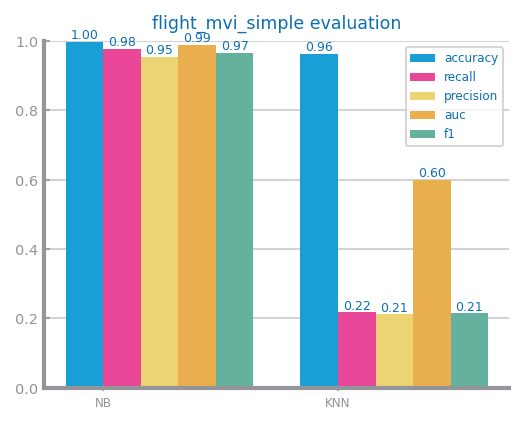

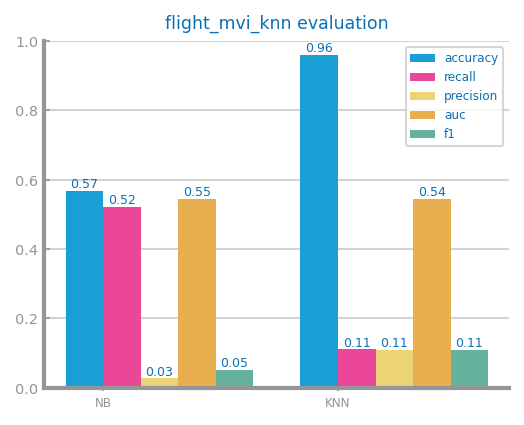

In [10]:
print("\n=== MVI EVALUATION (NB + KNN) ===")

# --- Simple-imputer MVI ---
figure()
eval_simple = evaluate_approach(
    train_simple_eval.copy(),
    test_simple_eval.copy(),
    target=target,
    metric="recall",   # same metric as encoding step
)
plot_multibar_chart(
    ["NB", "KNN"],
    eval_simple,
    title=f"{file_tag_simple} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/{file_tag_simple}_NB_KNN_recall_eval.png")
show()

# --- KNN-imputer MVI ---
figure()
eval_knn = evaluate_approach(
    train_knn_eval.copy(),
    test_knn_eval.copy(),
    target=target,
    metric="recall",
)
plot_multibar_chart(
    ["NB", "KNN"],
    eval_knn,
    title=f"{file_tag_knn} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/{file_tag_knn}_NB_KNN_recall_eval.png")
show()

In [ ]:
file_tag = "flight_mvi_simple"
target = "Cancelled"
eval_metric = "accuracy"   

# work from the already-prepared SIMPLE-MVI eval sets
train_df = train_simple_eval.copy()
test_df  = test_simple_eval.copy()

trnY = train_df[target].values
tstY = test_df[target].values

trnX = train_df.drop(columns=[target]).values
tstX = test_df.drop(columns=[target]).values

labels = sorted(list(set(trnY) | set(tstY)))
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=140000 Test#=60000
Labels=[np.int64(0), np.int64(1)]


<Figure size 600x450 with 0 Axes>

Best NB params: {'name': 'GaussianNB', 'metric': 'recall', 'params': (), 'recall': 0.9785661492978566}


<Figure size 600x450 with 0 Axes>

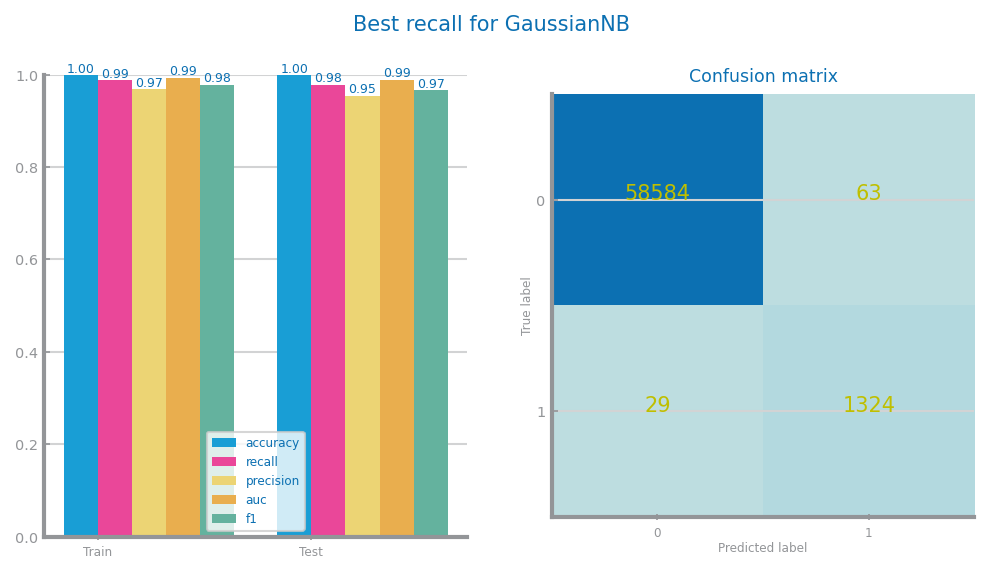

In [14]:
def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list[str] = []
    yvalues: list[float] = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance: float = 0.0

    for clf_name in estimators:
        xvalues.append(clf_name)
        clf = estimators[clf_name]
        clf.fit(trnX, trnY)
        prdY: array = clf.predict(tstX)
        eval_val: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval_val - best_performance > DELTA_IMPROVE:
            best_performance = eval_val
            best_params["name"] = clf_name
            best_params[metric] = eval_val
            best_model = clf
        yvalues.append(eval_val)

    return best_model, best_params

# ---- NB study on SIMPLE-MVI dataset ----
figure()
best_nb_model, nb_params = naive_Bayes_study(trnX, trnY, tstX, tstY, metric=eval_metric)
savefig(f"../../charts/lab3_preparation/{file_tag}_nb_{eval_metric}_study.png")
show()

print("Best NB params:", nb_params)

# ---- NB confusion matrix + metrics ----
prd_trn_nb: array = best_nb_model.predict(trnX)
prd_tst_nb: array = best_nb_model.predict(tstX)

figure()
plot_evaluation_results(nb_params, trnY, prd_trn_nb, tstY, prd_tst_nb, labels)
savefig(f"../../charts/lab3_preparation/{file_tag}_nb_{nb_params['name']}_best_{nb_params['metric']}_eval.png")
show()


In [18]:
def knn_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    k_max: int = 19,
    lag: int = 2,
    metric: str = "accuracy",
) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal["manhattan", "euclidean", "chebyshev"]] = [
        "manhattan",
        "euclidean",
        "chebyshev",
    ]

    kvalues: list[int] = [i for i in range(1, k_max + 1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {"name": "KNN", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list[float] = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval_val: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval_val)
            if eval_val - best_performance > DELTA_IMPROVE:
                best_performance = eval_val
                best_params["params"] = (k, d)
                best_model = clf
        values[d] = y_tst_values

    print(
        f'KNN best with k={best_params["params"][0]} and '
        f'{best_params["params"][1]} ({metric}={best_performance:.4f})'
    )

    plot_multiline_chart(
        kvalues,
        values,
        title=f"KNN Models ({metric})",
        xlabel="k",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

Train#=140000 Test#=60000
Labels=[np.int64(0), np.int64(1)]
KNN best with k=3 and manhattan (accuracy=0.9777)


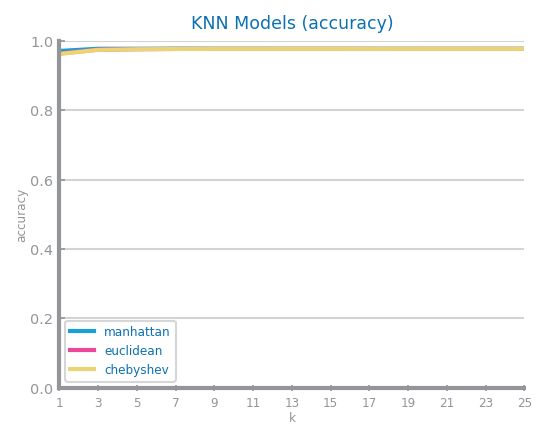

<Figure size 600x450 with 0 Axes>

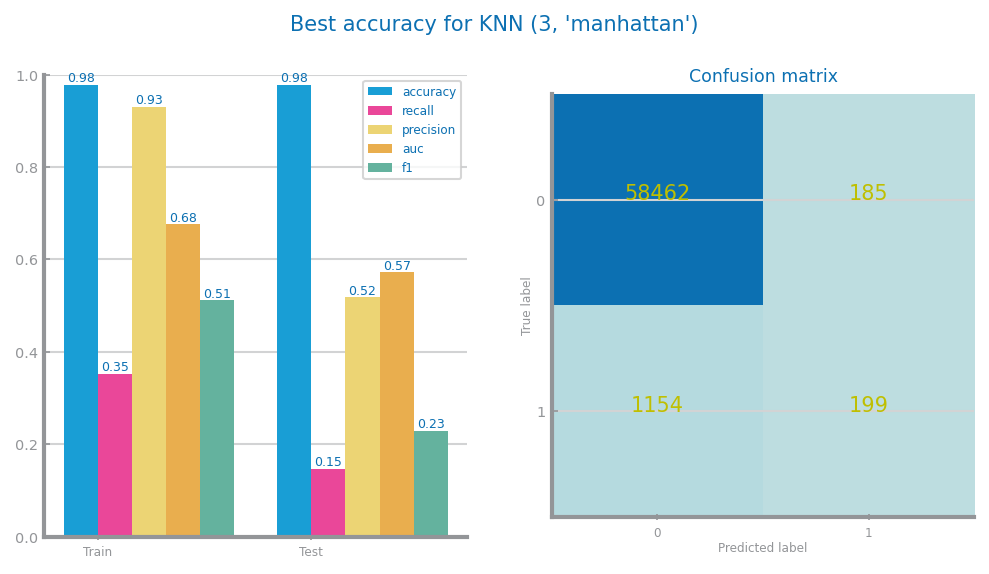

In [19]:
file_tag = "flight_mvi_simple"
eval_metric = "accuracy"   

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

# ---- KNN param search + study plot ----
figure()
best_knn, knn_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
#savefig(f"../../charts/lab3_preparation/{file_tag}_knn_{eval_metric}_study.png")
#show()

# ---- KNN confusion matrix + metrics ----
prd_trn_knn = best_knn.predict(trnX)
prd_tst_knn = best_knn.predict(tstX)

figure()
plot_evaluation_results(
    knn_params,
    trnY,
    prd_trn_knn,
    tstY,
    prd_tst_knn,
    labels,
)
savefig(f"../../charts/lab3_preparation/{file_tag}_knn_{knn_params['name']}_best_{knn_params['metric']}_eval.png")
show()

# Saving Updated Data with Best Method

In [21]:
# for full data run, need to maintain train/test split hygiene

input_path  = "../../data/prepared/flight_enc2.csv"
output_path = "../../data/prepared/flight_mvi1.csv"
target = "Cancelled"

print("Reading original encoded data from:", input_path)
full_raw = read_csv(input_path, na_values="")
print("Original shape:", full_raw.shape)

full_simple, _ = mvi_simple(full_raw, full_raw, target=target)

full_simple.to_csv(output_path, index=False)

print("\nSaved full MVI dataset →", output_path)
print("Final shape:", full_simple.shape)
print("Columns:", list(full_simple.columns))

Reading original encoded data from: ../../data/prepared/flight_enc2.csv
Original shape: (200000, 61)

Saved full MVI dataset → ../../data/prepared/flight_mvi1.csv
Final shape: (200000, 61)
Columns: ['ActualElapsedTime', 'AirTime', 'Airline', 'ArrDel15', 'ArrDelay', 'ArrDelayMinutes', 'ArrTime', 'ArrTimeBlk', 'ArrivalDelayGroups', 'CRSArrTime', 'CRSDepTime', 'CRSElapsedTime', 'DOT_ID_Marketing_Airline', 'DOT_ID_Operating_Airline', 'DayOfWeek', 'DayofMonth', 'DepDel15', 'DepDelay', 'DepDelayMinutes', 'DepTime', 'DepTimeBlk', 'DepartureDelayGroups', 'Dest', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'Distance', 'DistanceGroup', 'DivAirportLandings', 'Diverted', 'FlightDate', 'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline', 'IATA_Code_Marketing_Airline', 'IATA_Code_Operating_Airline', 'Marketing_Airline_Network', 'Month', 'Operated_or_Branded_Code_Share_Partners', 'Operating_Airline